In [2]:
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
from PIL import Image
import os
import math

In [3]:
interpreter = tf.lite.Interpreter(model_path = r'movenet.tflite')
interpreter.allocate_tensors()

In [68]:
global landmarksList, labelsList
landmarksList, labelsList = [], []


In [69]:
import cv2

def apply_landmarks_to_dataframe(frame, label):
    # Resize the frame to 192x192 with pads to maintain aspect ratio
    original_height, original_width = frame.shape[:2]

    aspect_ratio = original_width / original_height
    target_aspect_ratio = 1

    if aspect_ratio > target_aspect_ratio:
        new_width = 192
        new_height = int(192 / aspect_ratio)
    else:
        new_height = 192
        new_width = int(192 * aspect_ratio)

    # Resize the image
    resized_image = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Calculate padding
    top_padding = (192 - new_height) // 2
    bottom_padding = 192 - new_height - top_padding
    left_padding = (192 - new_width) // 2
    right_padding = 192 - new_width - left_padding

    # Add padding
    padded_image = cv2.copyMakeBorder(
        resized_image,
        top_padding,
        bottom_padding,
        left_padding,
        right_padding,
        cv2.BORDER_CONSTANT,
        value=(0, 0, 0)
    )

    input_image = tf.cast(padded_image , dtype=tf.float32)
    input_image = tf.expand_dims(input_image, axis=0)


    #use movenetlightning model to get landmarks from the frame
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()


    #predict landmarks
    interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    landmarks = keypoints_with_scores

    landmarksList.append(landmarks)
    labelsList.append(label)


    

def separate_video_frames(video_path, label):
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error: Could not open video.")
        return
    
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        apply_landmarks_to_dataframe(frame , label)
        apply_landmarks_to_dataframe(cv2.flip(frame, 1) , label)
        
        frame_count += 1
        
        # Press 'q' to exit the loop early
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

video_path = f'trainDataset/incorrect_backward.mp4'
separate_video_frames(video_path,3)

In [70]:
landmarks = []
for landmark in landmarksList:
    landmarks.append(landmark[0][0])

Add Landmark values to a dataframe
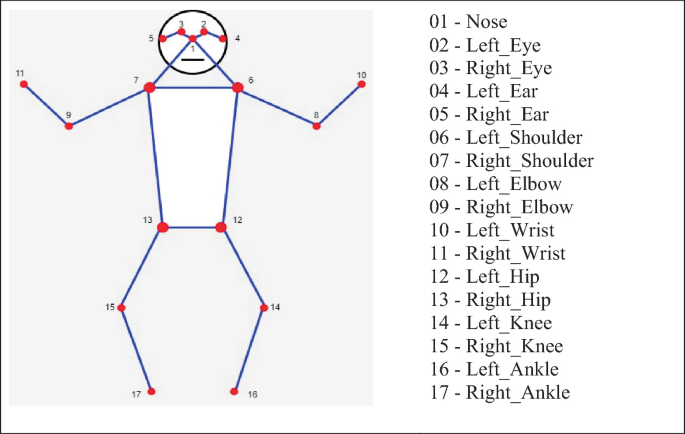

In [71]:
def add_landmarks_to_dataframe(landmarks, label):
    # add all landmark values and labels to a dataframe. x,y coordinates of each landmark separately should be stored, column names are of body parts
    columns = ['nose_x','nose_y','left_eye_x','left_eye_y','right_eye_x','right_eye_y','left_ear_x','left_ear_y','right_ear_x','right_ear_y','left_shoulder_x','left_shoulder_y','right_shoulder_x','right_shoulder_y','left_elbow_x','left_elbow_y','right_elbow_x','right_elbow_y','left_wrist_x','left_wrist_y','right_wrist_x','right_wrist_y','left_hip_x','left_hip_y','right_hip_x','right_hip_y','left_knee_x','left_knee_y','right_knee_x','right_knee_y','left_ankle_x','left_ankle_y','right_ankle_x','right_ankle_y','label']
    print(len(columns))

    df = pd.DataFrame(columns=columns)

    for x in range (0,len(landmarks)):
        df.loc[x] = [landmarks[x][0][0],landmarks[x][0][1],landmarks[x][1][0],landmarks[x][1][1],landmarks[x][2][0],landmarks[x][2][1],landmarks[x][3][0],landmarks[x][3][1],landmarks[x][4][0],landmarks[x][4][1],landmarks[x][5][0],landmarks[x][5][1],landmarks[x][6][0],landmarks[x][6][1],landmarks[x][7][0],landmarks[x][7][1],landmarks[x][8][0],landmarks[x][8][1],landmarks[x][9][0],landmarks[x][9][1],landmarks[x][10][0],landmarks[x][10][1],landmarks[x][11][0],landmarks[x][11][1],landmarks[x][12][0],landmarks[x][12][1],landmarks[x][13][0],landmarks[x][13][1],landmarks[x][14][0],landmarks[x][14][1],landmarks[x][15][0],landmarks[x][15][1],landmarks[x][16][0],landmarks[x][16][1],label]
    return df

In [72]:
df = add_landmarks_to_dataframe(landmarks,3)
print(df.shape)

35
(1872, 35)


In [73]:
df.head()

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,...,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,label
0,0.280236,0.430386,0.251344,0.430874,0.250961,0.432507,0.210032,0.489651,0.207592,0.487054,...,0.556869,0.990881,0.544770,0.989305,0.519906,0.986678,0.719524,0.984354,0.718385,3.0
1,0.269981,0.565324,0.240391,0.564215,0.239377,0.565580,0.201299,0.503307,0.200347,0.501308,...,0.423298,0.991617,0.502891,0.998149,0.447430,0.988599,0.302118,0.988940,0.298510,3.0
2,0.281479,0.431232,0.252527,0.431423,0.252152,0.433285,0.211556,0.489356,0.208628,0.489587,...,0.557867,0.991646,0.544565,0.989907,0.520923,0.986940,0.718060,0.984888,0.717708,3.0
3,0.271053,0.565114,0.241660,0.563764,0.240513,0.564910,0.202871,0.502671,0.201449,0.500018,...,0.424162,0.991807,0.502757,0.998667,0.447927,0.988242,0.302389,0.988484,0.299070,3.0
4,0.281126,0.431326,0.252195,0.431599,0.251836,0.433458,0.211254,0.488843,0.208230,0.489091,...,0.557891,0.992069,0.536564,0.989490,0.520170,0.986490,0.714989,0.984616,0.714721,3.0


Calculate angles and Relative distances

In [74]:
def calculate_angles(a, b, c):
    
    # Vectors from points
    vec_1 = [a[0] - b[0], a[1] - b[1]]
    vec_2 = [c[0] - b[0], c[1] - b[1]]
    
    # Dot product
    dot_product = vec_1[0] * vec_2[0] + vec_1[1] * vec_2[1]
    
    # Magnitudes of the vectors
    mag_1 = math.sqrt(vec_1[0]**2 + vec_1[1]**2)
    mag_2 = math.sqrt(vec_2[0]**2 + vec_2[1]**2)
    
    # Angle in radians
    angle_rad = math.acos(dot_product / (mag_1 * mag_2))
    
    # Convert to degrees
    angle_deg = math.degrees(angle_rad)
    
    return angle_deg

def calculate_dist(a,b):
    x_diff = a[0] - b[0]
    y_diff = a[1] - b[1]
    dist = math.sqrt(x_diff**2 + y_diff**2)
    return dist

In [75]:

def get_angle_dataframe(df, necessary_angles):
    # Calculate angles between necessary points
    df_angles = pd.DataFrame()

    if 'elbow_angle' in necessary_angles:
        df_angles['left_elbow_angle'] = df.apply(lambda x: calculate_angles([x['left_shoulder_x'], x['left_shoulder_y']], [x['left_elbow_x'], x['left_elbow_y']], [x['left_wrist_x'], x['left_wrist_y']]), axis=1)
        df_angles['right_elbow_angle'] = df.apply(lambda x: calculate_angles([x['right_shoulder_x'], x['right_shoulder_y']], [x['right_elbow_x'], x['right_elbow_y']], [x['right_wrist_x'], x['right_wrist_y']]), axis=1)
    if 'shoulder_angle' in necessary_angles:
        df_angles['left_shoulder_angle'] = df.apply(lambda x: calculate_angles([x['left_hip_x'], x['left_hip_y']], [x['left_shoulder_x'], x['left_shoulder_y']], [x['left_elbow_x'], x['left_elbow_y']]), axis=1)
        df_angles['right_shoulder_angle'] = df.apply(lambda x: calculate_angles([x['right_hip_x'], x['right_hip_y']], [x['right_shoulder_x'], x['right_shoulder_y']], [x['right_elbow_x'], x['right_elbow_y']]), axis=1)
    if 'hip_angle' in necessary_angles:
        df_angles['left_hip_angle'] = df.apply(lambda x: calculate_angles([x['left_shoulder_x'], x['left_shoulder_y']], [x['left_hip_x'], x['left_hip_y']], [x['left_knee_x'], x['left_knee_y']]), axis=1)
        df_angles['right_hip_angle'] = df.apply(lambda x: calculate_angles([x['right_shoulder_x'], x['right_shoulder_y']], [x['right_hip_x'], x['right_hip_y']], [x['right_knee_x'], x['right_knee_y']]), axis=1)
    if 'knee_angle' in necessary_angles:
        df_angles['left_knee_angle'] = df.apply(lambda x: calculate_angles([x['left_hip_x'], x['left_hip_y']], [x['left_knee_x'], x['left_knee_y']], [x['left_ankle_x'], x['left_ankle_y']]), axis=1)
        df_angles['right_knee_angle'] = df.apply(lambda x: calculate_angles([x['right_hip_x'], x['right_hip_y']], [x['right_knee_x'], x['right_knee_y']], [x['right_ankle_x'], x['right_ankle_y']]), axis=1)
    df_angles['label'] = df['label']
    return df_angles

In [76]:
df_angles = get_angle_dataframe(df, ['elbow_angle', 'shoulder_angle'])

In [77]:
df_angles.shape

(1872, 5)

In [78]:
df_angles

,left_elbow_angle,right_elbow_angle,left_shoulder_angle,right_shoulder_angle,label
0,88.083215,115.640463,26.293006,17.783749,3.0
1,124.215786,94.470369,11.636734,24.859179,3.0
2,88.901512,116.264702,26.368336,17.628039,3.0
3,123.486947,94.235758,12.094365,24.938387,3.0
4,88.512883,116.214976,26.390784,17.570480,3.0
...,...,...,...,...,...
1867,64.468704,46.396880,7.693093,26.482037,3.0
1868,45.288146,58.889554,28.907793,17.067451,3.0
1869,66.801457,46.458142,4.477478,26.493856,3.0
1870,46.842342,60.548671,28.554667,17.613786,3.0


In [79]:
df_angles.to_csv('bicep_curls_incorrect_backward.csv', index=False)